In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import re

from sklearn import manifold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Settings
Define an output folder containing saved results from run_ensemble.py

In [2]:
ensemble_model_output_folder = 'ensemble_inter_dev'
### PICK ONE OF:
    # 'ensemble_inter_cola_dev'
    # 'ensemble_inter_cola_test'
    # 'ensemble_inter_dev'
    # 'ensemble_inter_test'
    # 'ensemble_inter_twitter'
    # 'ensemble_inter_twitter_balanced'


# which varieties of interpretability ensembles should we generate?
agreement_metrics = [['Lime_agreement'],
                     ['Shap_agreement'],
                     ['Attention_agreement'],
                     ['Integrated_Grad_agreement'],
                     #['Lime_agreement', 'Integrated_Grad_agreement'],
                     #['Lime_agreement', 'Attention_agreement'],
                     #['Lime_agreement', 'Shap_agreement'],
                     #['Shap_agreement', 'Attention_agreement'],
                     #['Shap_agreement', 'Integrated_Grad_agreement'],
                     #['Attention_agreement', 'Integrated_Grad_agreement'],
                     ['Lime_agreement', 'Shap_agreement', 'Attention_agreement', 'Integrated_Grad_agreement']
                    ]

### Generate performance metrics
(will calculate interpretability weighted ensemble predictions for each item in agreement_metrics)

In [3]:
#df = pd.read_csv(f'../results/{ensemble_model_output_folder}/all_constituent_predictions_ensemble_model.csv')
df = pd.read_pickle(f'../results/{ensemble_model_output_folder}/all_constituent_predictions_ensemble_model.pkl')

In [4]:
### individual model predictions ###
models = sorted(list(set(df['Model_id'].values)))

all_ensemble_preds = df[df['Model_id'] == models[0]][['Test_example', 'True Label', 'Tokens_unified']]

for m in models:
    all_ensemble_preds[m] = df[df['Model_id'] == m]['Probability for Hate'].values

### majority vote baseline ###
all_ensemble_preds['majority_baseline'] = all_ensemble_preds[models].median(axis=1)

### straight avg baseline ###
all_ensemble_preds['straight_avg_baseline'] = all_ensemble_preds[models].mean(axis=1)


### interpretability weighted predictions ###

# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=temp.loc[x.index, "agreement"])

for mt in agreement_metrics:
    
    temp = df[['Test_example', 'Model_id', 'Probability for Hate']].copy()
    temp['agreement'] = df[mt].mean(axis=1)
    modal_vote = temp.loc[temp.groupby("Test_example")["agreement"].idxmax()]['Probability for Hate'].values
    wtd_vote = temp.groupby(["Test_example"]).agg(wtd_vote=("Probability for Hate", wm)).wtd_vote.values
    all_ensemble_preds[f"{'_'.join(mt)}_modal_vote"] = modal_vote
    all_ensemble_preds[f"{'_'.join(mt)}_wtd_avg"] = wtd_vote

In [5]:
# Calculate ensemble metrics
def calc_metrics(all_ensemble_preds):

    precisions = []
    recalls = []
    f1_scores = []
    accuracies = []

    for ensemble_pred in all_ensemble_preds.columns[3:]:
            y_true = np.array(all_ensemble_preds['True Label'])
            y_pred = np.array(all_ensemble_preds[ensemble_pred] >= 0.5)
            tp, fn, fp, tn = confusion_matrix(y_true, y_pred, labels=[1,0]).ravel()
            precisions.append(tp / (tp + fp))
            recalls.append(tp / (tp + fn))
            f1_scores.append(2 * tp / (2*tp + fp + fn))
            accuracies.append((tp + tn) / (tp + tn + fp + fn))


    metrics = pd.DataFrame({'model': all_ensemble_preds.columns[3:],
                            'precision': precisions,
                            'recall': recalls,
                            'f1_score': f1_scores,
                            'accuracy': accuracies})
    return metrics

metrics = calc_metrics(all_ensemble_preds)
#metrics

In [6]:
# Calculate confidence intervals around metrics (using bootstrapping)
num_bootstraps = 1000

bootstrap_metrics = pd.DataFrame({'model': pd.Series(dtype='str'),
                                  'precision': pd.Series(dtype='str'),
                                  'recall': pd.Series(dtype='str'),
                                  'f1_score': pd.Series(dtype='str'),
                                  'accuracy': pd.Series(dtype='str')})

for i in range(num_bootstraps):
    
    all_ensemble_preds_bootstrap = all_ensemble_preds.sample(n=all_ensemble_preds.shape[0],
                                                             replace=True, random_state=i)
    bootstrap_metrics = pd.concat([bootstrap_metrics,
                                   calc_metrics(all_ensemble_preds_bootstrap)])

# calculate std dev of each metric (based on empirical bootstrap samples)
bootstrap_metrics_agg = bootstrap_metrics.groupby('model').agg(precision_std = ('precision', np.std),
                                                           recall_std = ('recall', np.std),
                                                           f1_score_std = ('f1_score', np.std),
                                                           accuracy_std = ('accuracy', np.std)).reset_index()


# combine the bootrap metrics for each set of [three random seed models]
bootstrap_metrics_indvd_models_only = bootstrap_metrics[[any(char.isdigit() for char in mod) for mod in bootstrap_metrics['model']]].copy()

bootstrap_metrics_indvd_models_only['model'] = [re.sub(r'\_\d', '', a)+'_agg' for a in bootstrap_metrics_indvd_models_only['model']]
bootstrap_metrics_indvd_models_only = bootstrap_metrics_indvd_models_only.groupby('model').agg(precision = ('precision', np.mean),
                                                         recall = ('recall', np.mean),
                                                         f1_score = ('f1_score', np.mean),
                                                         accuracy = ('accuracy', np.mean),
                                                         precision_std = ('precision', np.std),
                                                         recall_std = ('recall', np.std),
                                                         f1_score_std = ('f1_score', np.std),
                                                         accuracy_std = ('accuracy', np.std)).reset_index()


# join confidence intervals to original metrics
final_metrics = pd.merge(left = metrics, right = bootstrap_metrics_agg, on = 'model')
final_metrics = pd.concat([final_metrics, bootstrap_metrics_indvd_models_only])
final_metrics

,model,precision,recall,f1_score,accuracy,precision_std,recall_std,f1_score_std,accuracy_std
0,bert_medium_rand_1,0.780303,0.858333,0.817460,0.807531,0.036297,0.032116,0.026066,0.025629
1,bert_medium_rand_2,0.751773,0.883333,0.812261,0.794979,0.035942,0.029095,0.025659,0.025921
2,bert_medium_rand_3,0.781955,0.866667,0.822134,0.811715,0.034702,0.031867,0.025450,0.024869
3,bert_rand_1,0.846154,0.825000,0.835443,0.836820,0.032187,0.035369,0.026258,0.023738
4,bert_rand_2,0.830508,0.816667,0.823529,0.824268,0.033512,0.036054,0.026791,0.024527
5,bert_rand_3,0.809524,0.850000,0.829268,0.824268,0.034725,0.032337,0.025969,0.024778
6,roberta_rand_1,0.760000,0.791667,0.775510,0.769874,0.037187,0.037406,0.029177,0.026750
7,roberta_rand_2,0.810811,0.750000,0.779221,0.786611,0.036527,0.040601,0.030509,0.026419
8,roberta_rand_3,0.774194,0.800000,0.786885,0.782427,0.036751,0.037309,0.029070,0.027076
9,majority_baseline,0.807692,0.875000,0.840000,0.832636,0.033951,0.030375,0.025044,0.024527


### Signif. test for one model better than another


p-value for Lime_agreement_Shap_agreement_Attention_agreement_Integrated_Grad_agreement_wtd_avg being better than straight_avg_baseline: 0.629



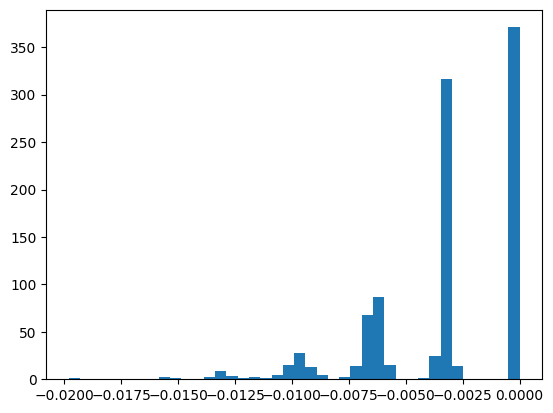

In [7]:
model_a = 'Lime_agreement_Shap_agreement_Attention_agreement_Integrated_Grad_agreement_wtd_avg'
model_b = 'straight_avg_baseline'

f1_metrics_a = bootstrap_metrics[bootstrap_metrics['model'] == model_a].f1_score
f1_metrics_b = bootstrap_metrics[bootstrap_metrics['model'] == model_b].f1_score
diff_metrics = [a - b for a, b in zip(f1_metrics_a, f1_metrics_b)]

p_value = (np.array(diff_metrics) < 0).mean()
print(f"""\np-value for {model_a} being better than {model_b}: {round(p_value, 4)}\n""")
plt.hist(diff_metrics, bins = 40)
plt.show()

### Performance metric plot

In [8]:
# Pick which models to include on plot:
constituent_models_for_plot = {
    #'bert_medium_rand_1': 'B-medium_1',
    #'bert_medium_rand_2': 'B-medium_2',
    #'bert_medium_rand_3': 'B-medium_3',
    #'bert_rand_1': 'Bert_1',
    #'bert_rand_2': 'Bert_2',
    #'bert_rand_3': 'Bert_3',
    #'roberta_rand_1': 'Roberta_1',
    #'roberta_rand_2': 'Roberta_2',
    #'roberta_rand_3': 'Roberta_3',
    'bert_medium_rand_agg': 'B-medium',
    'bert_rand_agg': 'Bert',
    'roberta_rand_agg': 'Roberta',
}

baseline_models_for_plot = {
    'majority_baseline': 'Majority Vote',
    'straight_avg_baseline': 'Straight Avg',
}

inter_models_for_plot_modal = {
    'Lime_agreement_modal_vote': 'Lime ',
    'Shap_agreement_modal_vote': 'SHAP ',
    'Attention_agreement_modal_vote': 'Attn ',
    'Integrated_Grad_agreement_modal_vote': 'IntGr ',
    'Lime_agreement_Shap_agreement_Attention_agreement_Integrated_Grad_agreement_modal_vote': 'Combined ',
}
    
inter_models_for_plot_wtd_avg = {
    'Lime_agreement_wtd_avg': 'Lime',
    'Shap_agreement_wtd_avg': 'SHAP',
    'Attention_agreement_wtd_avg': 'Attn',
    'Integrated_Grad_agreement_wtd_avg': 'IntGr',
    'Lime_agreement_Shap_agreement_Attention_agreement_Integrated_Grad_agreement_wtd_avg': 'Combined',
}

metric_to_plot = 'f1_score'

plot_title = 'Performance Comparison - Hate Speech Dev Set'

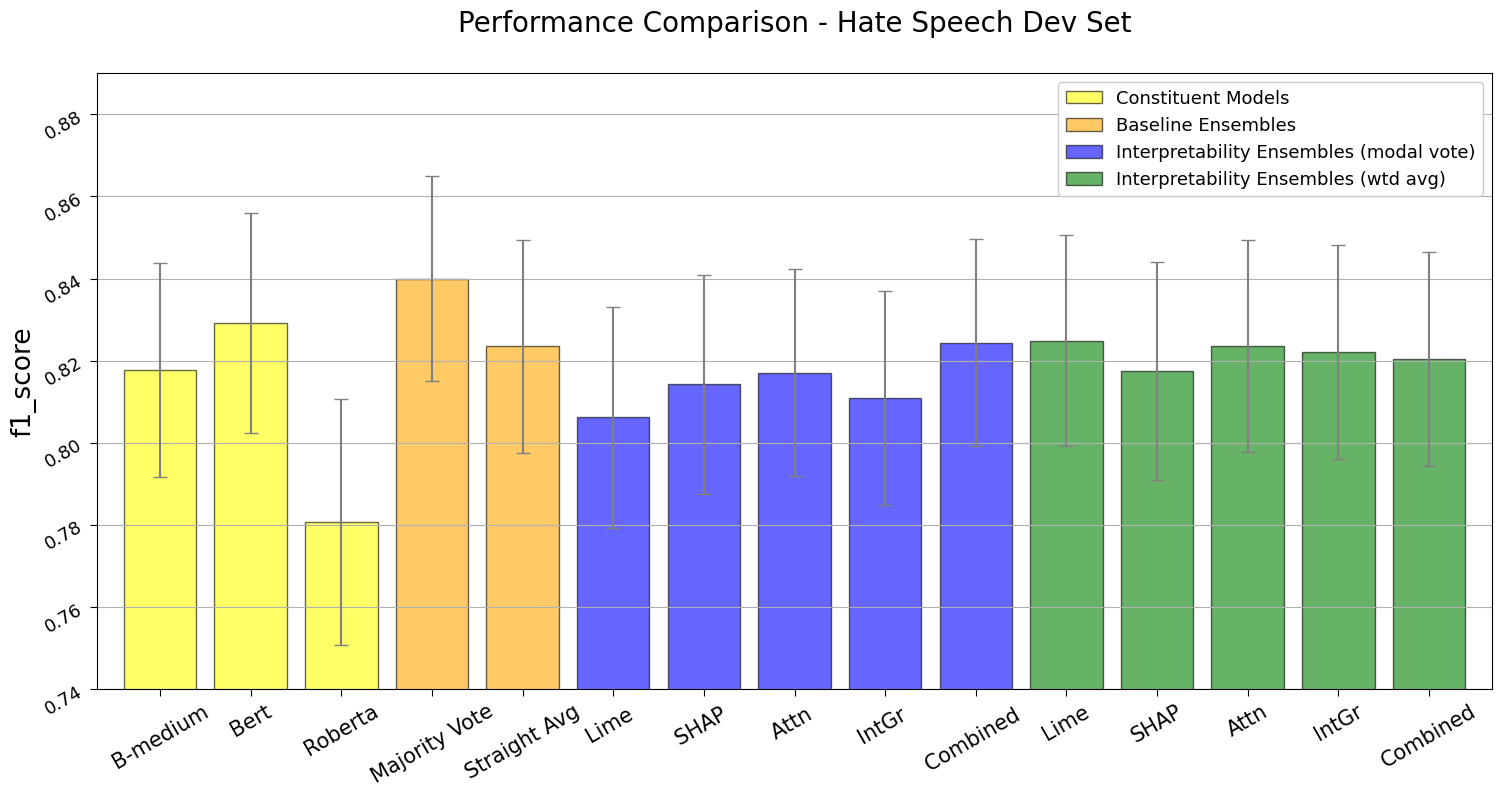

In [9]:
x_keys = list(constituent_models_for_plot.keys()) + list(baseline_models_for_plot.keys()) + list(inter_models_for_plot_modal.keys()) + list(inter_models_for_plot_wtd_avg.keys())
x_labs = list(constituent_models_for_plot.values()) + list(baseline_models_for_plot.values()) + list(inter_models_for_plot_modal.values()) + list(inter_models_for_plot_wtd_avg.values())
colours = ['yellow'] * len(constituent_models_for_plot) + ['orange'] * len(baseline_models_for_plot) + ['blue'] * len(inter_models_for_plot_modal) + ['green'] * len(inter_models_for_plot_wtd_avg)
s_labs = ['Constituent Models'] * len(constituent_models_for_plot) + ['Baseline Ensembles'] * len(baseline_models_for_plot) + ['Interpretability Ensembles (modal vote)'] * len(inter_models_for_plot_modal) + ['Interpretability Ensembles (wtd avg)'] * len(inter_models_for_plot_wtd_avg)
y = final_metrics.set_index('model').loc[x_keys][metric_to_plot]
err = final_metrics.set_index('model').loc[x_keys][metric_to_plot+'_std']
y_max = 0.01 + math.ceil(50 * (y + err).max()) / 50
y_min = math.floor(50 * (y - err).min()) / 50

fig, axs = plt.subplots(figsize = (18,8))
axs.bar(x = x_labs, height = y, edgecolor = "black",
        yerr=err, ecolor = "grey", capsize=5,
        color = colours, label = s_labs, alpha = 0.6)
axs.set_ylabel(metric_to_plot, fontsize=19)
axs.tick_params(size=5, rotation=30)
axs.set_ylim(bottom=y_min, top=y_max)
plt.title(plot_title, pad = 30, size = 20)

plt.yticks(fontsize=13)
plt.xticks(fontsize=15)

	
plt.grid(axis = 'y')

plt.margins(x=0.02, tight=True)

# deduplicate the legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), framealpha = 1, fontsize = 13)


plt.show()
fig.savefig(f"../results/{plot_title}.svg")

### Quick plot to see what the average agreement (and spread) is across test examples

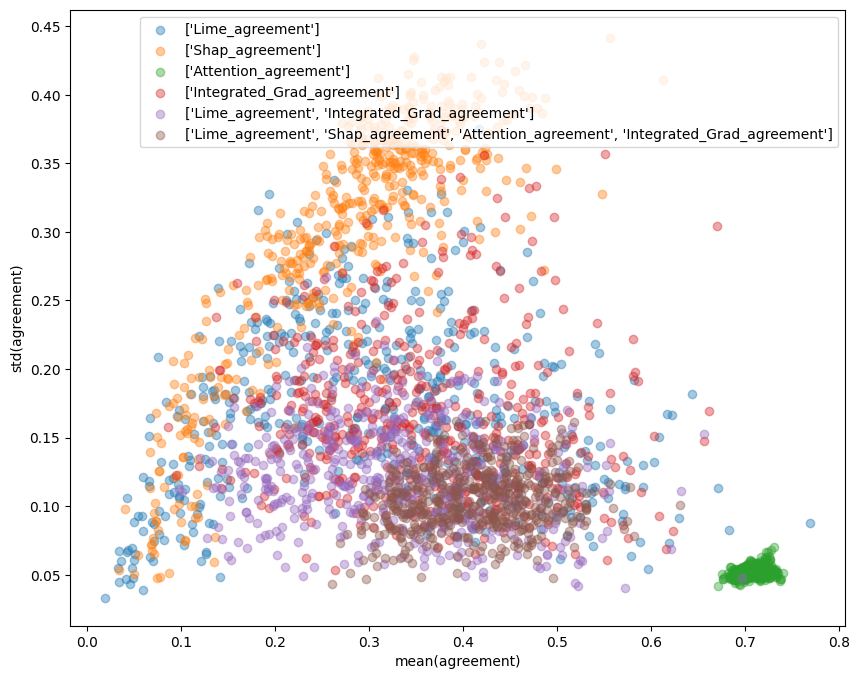

In [37]:
plt.figure(figsize=(10,8))
for mt in agreement_metrics:
    temp = df[['Test_example']].copy()
    temp['agreement'] = df[mt].mean(axis=1)
     
    stds = temp.groupby('Test_example')['agreement'].std()
    means = temp.groupby('Test_example')['agreement'].mean()

    plt.scatter(x = means, y = stds, label = mt, alpha = 0.4)
    plt.xlabel('mean(agreement)')
    plt.ylabel('std(agreement)')
    plt.legend()

### 2D Agreement plots for specific examples

In [572]:


def simil(a, b, simil_type = 'cosine'):
    if simil_type == 'cosine':
        return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    elif simil_type == 'dot':
        return np.dot(a, b)
    
# These examples are hatespeech, where our inter ensemble gets it right and majority baseline gets it wrong
np.where(((all_ensemble_preds['True Label'] == 1) & (all_ensemble_preds['Lime_agreement_Shap_agreement_Attention_agreement_Integrated_Grad_agreement_modal_vote'] > 0.5) & (all_ensemble_preds['majority_baseline'] < 0.5)))

(array([ 59, 256]),)

In [573]:
# Which example shall we look at?
idx = 256 # 98 is a good one for hate speech dev, 256 good one for COLA dev

simil_type = 'cosine' # 'cosine' or 'dot'

Interpretability ensemble modal vote takes the following model: cola_bert_rand_2_dev


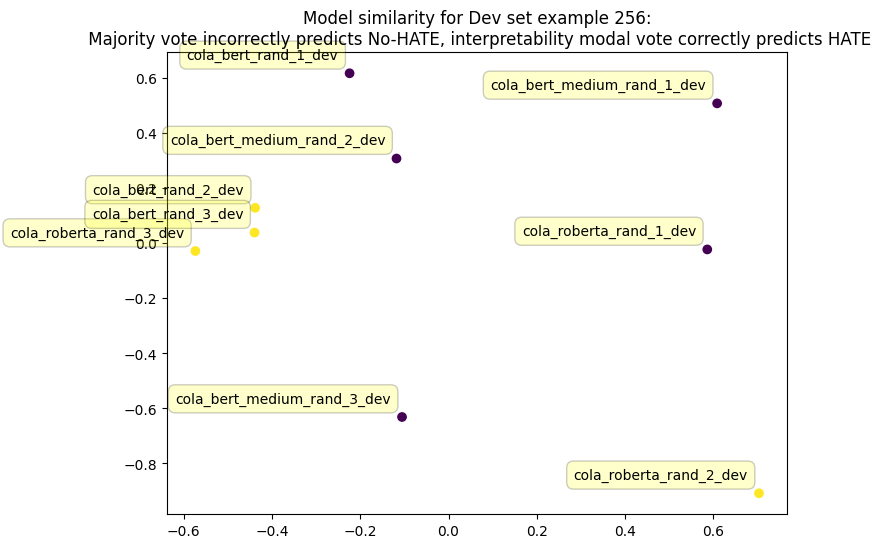

In [574]:
this_example = df[df['Test_example'] == idx].copy()

lime_scores = this_example['Lime_unified'].values
shap_scores = this_example['Shap_unified'].values + 1e-8
attn_scores = this_example['Attention_unified'].values
intg_scores = this_example['Integrated_Grad_unified'].values

lime_agreement = np.array([[simil(a, b, simil_type) for b in lime_scores] for a in lime_scores])
shap_agreement = np.array([[simil(a, b, simil_type) for b in shap_scores] for a in shap_scores])
attn_agreement = np.array([[simil(a, b, simil_type) for b in attn_scores] for a in attn_scores])
intg_agreement = np.array([[simil(a, b, simil_type) for b in intg_scores] for a in intg_scores])

#dist_matrix = (1 - lime_agreement) + (1 - shap_agreement) + (1 - attn_agreement) + (1 - intg_agreement)
dist_matrix = (1 - lime_agreement)

# convert distance matrix to 2D embedding
mds = manifold.MDS(n_components=2, dissimilarity="precomputed",
                   random_state=42, normalized_stress = 'auto')
results = mds.fit(dist_matrix)
coords = results.embedding_

# plot the result
fix, axs = plt.subplots(figsize = (8,6))
axs.scatter(coords[:, 0], coords[:, 1], marker = 'o', c = this_example['Predicted Label'])#, s = (4 - dist_matrix).sum(axis=0))
#plt.legend()
plt.title(f'Model similarity for Dev set example {idx}:\n Majority vote incorrectly predicts No-HATE, interpretability modal vote correctly predicts HATE')
for label, x, y in zip(this_example['Model_id'], coords[:, 0], coords[:, 1]):
    plt.annotate(
        label[:-1] + label[-1],
        xy = (x, y), xytext = (-8, 8),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.2))

chosen_inter_model = this_example['Model_id'].values[dist_matrix.sum(axis=0).argmin()]
print(f"Interpretability ensemble modal vote takes the following model: {chosen_inter_model}")

<Axes: >

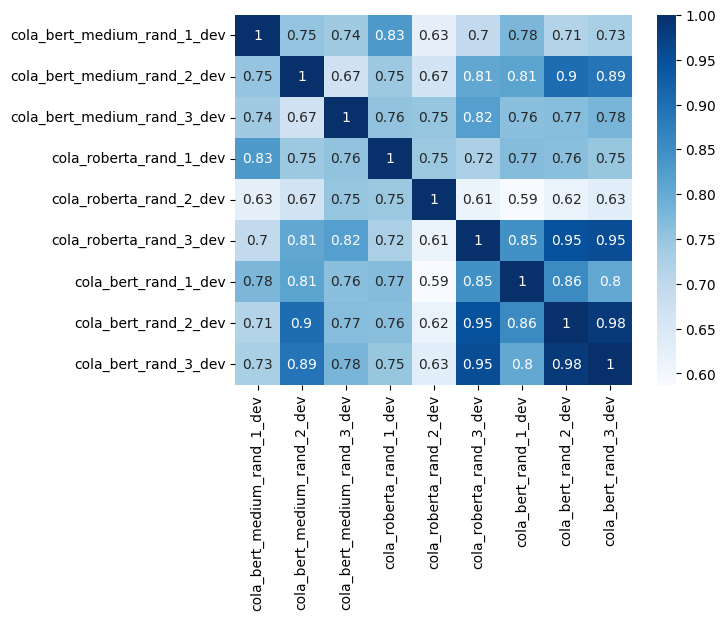

In [18]:


sns.heatmap((4 - dist_matrix)/4,
            xticklabels = this_example['Model_id'], yticklabels = this_example['Model_id'],
            cmap='Blues', annot=True)

In [19]:
' '.join(this_example['Tokens_unified'].values[0])

'<sos> they were taking a hard look at possible fta. <eos>'

In [23]:
from captum.attr import visualization as viz

toks = ['this', 'is', 'example', 'sentence']
interpretability = [-0.1, 0.2, -5, 4]

viz.visualize_text([viz.VisualizationDataRecord(word_attributions = interpretability,
                                                pred_prob = 0,  # this is irrelevant
                                                pred_class = 0, # this is irrelevant
                                                true_class = 0, # this is irrelevant
                                                attr_class = 0, # this is irrelevant
                                                attr_score = 0, # this is irrelevant
                                                raw_input_ids = toks,
                                                convergence_score = 0)])

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,this is example sentence


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,this is example sentence
